# L9: Evaluation Part II

Evaluate LLM responses where there isn't a single "right answer."

## Setup
#### Load the API key and relevant Python libaries.

The course includes a script that loads an OpenAI API key for you. However, in my implementation, I'm modifying the code to use the GROQ API instead.

The functions in the official course notebook were already improved from previous notebooks and adjusted to achieve the desired output here. To replicate the results, I took the following steps.  
1. Redefined and adjusted the implemented functions to meet my workflow requirements.  
2. Define and import the necessary variables. 
3. I used the `Inspect` library to look at the source code/logic for the function on the official website.

    ```bash
        import inspect
        # the function is already defined since it has been called
        source_code = inspect.getsource(utils.get_products_from_query)
        print(source_code)
    ```



In [7]:
import groq
# Checking the Groq version
print(groq.__version__)

0.5.0


In [8]:
import os
import sys
from groq import Groq
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

def get_completion_from_messages(messages, 
                                 model="llama3-70b-8192", 
                                 temperature=0, 
                                 max_tokens=500):
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature, # this is the degree of randomness of the model's output
        max_tokens=max_tokens, # the maximum number of tokens the model can ouptut 
    )
    return response.choices[0].message.content

In [ ]:
# The API key must be loaded for importing variables
%run L5:Process_Inputs_Chaining_Prompts.ipynb

## Helper functions

In [32]:
def get_products_from_query(user_msg, products_info):

    products_and_category = products_info
    delimiter = "####"
    system_message = f"""
    You will be provided with customer service queries. \
    The customer service query will be delimited with {delimiter} characters.
    Output a python list of json objects, where each object has the following format:
        'category': <one of Computers and Laptops, Smartphones and Accessories, Televisions and Home Theater Systems, \
    Gaming Consoles and Accessories, Audio Equipment, Cameras and Camcorders>,
    OR
        'products': <a list of products that must be found in the allowed products below>

    Where the categories and products must be found in the customer service query.
    If a product is mentioned, it must be associated with the correct category in the allowed products list below.
    If no products or categories are found, output an empty list.

    The allowed products are provided in JSON format.
    The keys of each item represent the category.
    The values of each item is a list of products that are within that category.
    Allowed products: {products_and_category}
    Only output the required format and no further messages either before or after it

    """
    
    messages =  [  
    {'role':'system', 'content': system_message},    
    {'role':'user', 'content': f"{delimiter}{user_msg}{delimiter}"},  
    ] 
    category_and_product_response = get_completion_from_messages(messages)
    
    return category_and_product_response

def get_mentioned_product_info(data_list):
    
    product_info_l = []

    if data_list is None:
        return product_info_l

    for data in data_list:
        try:
            if "products" in data:
                products_list = data["products"]
                for product_name in products_list:
                    product =  get_product_by_name(product_name)
                    if product:
                        product_info_l.append(product)
                    else:
                        print(f"Error: Product '{product_name}' not found")
            elif "category" in data:
                category_name = data["category"]
                category_products = get_products_by_category(category_name)
                for product in category_products:
                    product_info_l.append(product)
            else:
                print("Error: Invalid object format")
        except Exception as e:
            print(f"Error: {e}")

    return product_info_l

def answer_user_msg(user_msg,product_info):

    delimiter = "####"
    system_message = f"""
    You are a customer service assistant for a large electronic store. \
    Respond in a friendly and helpful tone, with concise answers. \
    Make sure to ask the user relevant follow up questions.
    """
    # user_msg = f"""
    # tell me about the smartx pro phone and the fotosnap camera, the dslr one. Also what tell me about your tvs"""
    messages =  [  
    {'role':'system', 'content': system_message},   
    {'role':'user', 'content': f"{delimiter}{user_msg}{delimiter}"},  
    {'role':'assistant', 'content': f"Relevant product information:\n{product_info}"},   
    ] 
    response = get_completion_from_messages(messages)
    return response

### Run through the end-to-end system to answer the user query

These helper functions are running the chain of promopts that you saw in the earlier videos.

In [33]:
customer_msg = f"""
tell me about the smartx pro phone and the fotosnap camera, the dslr one.
Also, what TVs or TV related products do you have?"""

products_by_category = get_products_from_query(customer_msg, products)
#the below function seems to be unneeded as the previous ourput is already parsed to the desired format!
category_and_product_list = read_string_to_list(products_by_category)
product_info = get_mentioned_product_info(category_and_product_list)
assistant_answer = answer_user_msg(user_msg=customer_msg, product_info=product_info)

In [34]:
print(assistant_answer)

I'd be happy to help you with that!

The SmartX Pro Phone is a powerful smartphone with advanced camera features. It has a 6.1-inch display, 128GB of storage, and a 12MP dual camera. It's also 5G-enabled, making it perfect for those who want a fast and reliable connection. The phone has a rating of 4.6 out of 5 stars and is priced at $899.99.

The FotoSnap DSLR Camera is a versatile camera that can capture stunning photos and videos. It has a 24.2MP sensor, can record 1080p video, and has a 3-inch LCD screen. It also has interchangeable lenses, making it perfect for photographers who want more creative control. The camera has a rating of 4.7 out of 5 stars and is priced at $599.99.

As for TVs and TV-related products, we have a range of options from CineView and SoundMax. We have the CineView 4K TV, which has a 55-inch display, 4K resolution, HDR, and smart TV features. It's priced at $599.99. We also have the CineView 8K TV, which has a 65-inch display, 8K resolution, HDR, and smart T

### Evaluate the LLM's answer to the user with a rubric, based on the extracted product information

In [35]:
cust_prod_info = {
    'customer_msg': customer_msg,
    'context': product_info
}


def eval_with_rubric(test_set, assistant_answer):

    cust_msg = test_set['customer_msg']
    context = test_set['context']
    completion = assistant_answer
    
    system_message = """\
    You are an assistant that evaluates how well the customer service agent \
    answers a user question by looking at the context that the customer service \
    agent is using to generate its response. 
    """

    user_message = f"""\
You are evaluating a submitted answer to a question based on the context \
that the agent uses to answer the question.
Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {cust_msg}
    ************
    [Context]: {context}
    ************
    [Submission]: {completion}
    ************
    [END DATA]

Compare the factual content of the submitted answer with the context. \
Ignore any differences in style, grammar, or punctuation.
Answer the following questions:
    - Is the Assistant response based only on the context provided? (Y or N)
    - Does the answer include information that is not provided in the context? (Y or N)
    - Is there any disagreement between the response and the context? (Y or N)
    - Count how many questions the user asked. (output a number)
    - For each question that the user asked, is there a corresponding answer to it?
      Question 1: (Y or N)
      Question 2: (Y or N)
      ...
      Question N: (Y or N)
    - Of the number of questions asked, how many of these questions were addressed by the answer? (output a number)
"""

    messages = [
        {'role': 'system', 'content': system_message},
        {'role': 'user', 'content': user_message}
    ]

    response = get_completion_from_messages(messages)
    return response

In [36]:
evaluation_output = eval_with_rubric(cust_prod_info, assistant_answer)
print(evaluation_output)

Here are the answers to the questions:

1. Is the Assistant response based only on the context provided? (Y)
2. Does the answer include information that is not provided in the context? (N)
3. Is there any disagreement between the response and the context? (N)
4. Count how many questions the user asked. (2)
5. For each question that the user asked, is there a corresponding answer to it?
   Question 1: (Y)
   Question 2: (Y)
6. Of the number of questions asked, how many of these questions were addressed by the answer? (2)


### Evaluate the LLM's answer to the user based on an "ideal" / "expert" (human generated) answer.

In [37]:
test_set_ideal = {
    'customer_msg': """\
tell me about the smartx pro phone and the fotosnap camera, the dslr one.
Also, what TVs or TV related products do you have?""",
    'ideal_answer':"""\
Of course!  The SmartX ProPhone is a powerful \
smartphone with advanced camera features. \
For instance, it has a 12MP dual camera. \
Other features include 5G wireless and 128GB storage. \
It also has a 6.1-inch display.  The price is $899.99.

The FotoSnap DSLR Camera is great for \
capturing stunning photos and videos. \
Some features include 1080p video, \
3-inch LCD, a 24.2MP sensor, \
and interchangeable lenses. \
The price is 599.99.

For TVs and TV related products, we offer 3 TVs \


All TVs offer HDR and Smart TV.

The CineView 4K TV has vibrant colors and smart features. \
Some of these features include a 55-inch display, \
'4K resolution. It's priced at 599.

The CineView 8K TV is a stunning 8K TV. \
Some features include a 65-inch display and \
8K resolution.  It's priced at 2999.99

The CineView OLED TV lets you experience vibrant colors. \
Some features include a 55-inch display and 4K resolution. \
It's priced at 1499.99.

We also offer 2 home theater products, both which include bluetooth.\
The SoundMax Home Theater is a powerful home theater system for \
an immmersive audio experience.
Its features include 5.1 channel, 1000W output, and wireless subwoofer.
It's priced at 399.99.

The SoundMax Soundbar is a sleek and powerful soundbar.
It's features include 2.1 channel, 300W output, and wireless subwoofer.
It's priced at 199.99

Are there any questions additional you may have about these products \
that you mentioned here?
Or may do you have other questions I can help you with?
    """
}

### Check if the LLM's response agrees with or disagrees with the expert answer

This evaluation prompt is from the [OpenAI evals](https://github.com/openai/evals/blob/main/evals/registry/modelgraded/fact.yaml) project.

[BLEU score](https://en.wikipedia.org/wiki/BLEU): another way to evaluate whether two pieces of text are similar or not.

In [39]:
def eval_vs_ideal(test_set, assistant_answer):

    cust_msg = test_set['customer_msg']
    ideal = test_set['ideal_answer']
    completion = assistant_answer
    
    system_message = """\
    You are an assistant that evaluates how well the customer service agent \
    answers a user question by comparing the response to the ideal (expert) response
    Output a single letter and nothing else. 
    """

    user_message = f"""\
You are comparing a submitted answer to an expert answer on a given question. Here is the data:
    [BEGIN DATA]
    ************
    [Question]: {cust_msg}
    ************
    [Expert]: {ideal}
    ************
    [Submission]: {completion}
    ************
    [END DATA]

Compare the factual content of the submitted answer with the expert answer. Ignore any differences in style, grammar, or punctuation.
    The submitted answer may either be a subset or superset of the expert answer, or it may conflict with it. Determine which case applies. Answer the question by selecting one of the following options:
    (A) The submitted answer is a subset of the expert answer and is fully consistent with it.
    (B) The submitted answer is a superset of the expert answer and is fully consistent with it.
    (C) The submitted answer contains all the same details as the expert answer.
    (D) There is a disagreement between the submitted answer and the expert answer.
    (E) The answers differ, but these differences don't matter from the perspective of factuality.
  choice_strings: ABCDE
"""

    messages = [
        {'role': 'system', 'content': system_message},
        {'role': 'user', 'content': user_message}
    ]

    response = get_completion_from_messages(messages)
    return response

In [40]:
print(assistant_answer)

I'd be happy to help you with that!

The SmartX Pro Phone is a powerful smartphone with advanced camera features. It has a 6.1-inch display, 128GB of storage, and a 12MP dual camera. It's also 5G-enabled, making it perfect for those who want a fast and reliable connection. The phone has a rating of 4.6 out of 5 stars and is priced at $899.99.

The FotoSnap DSLR Camera is a versatile camera that can capture stunning photos and videos. It has a 24.2MP sensor, can record 1080p video, and has a 3-inch LCD screen. It also has interchangeable lenses, making it perfect for photographers who want more creative control. The camera has a rating of 4.7 out of 5 stars and is priced at $599.99.

As for TVs and TV-related products, we have a range of options from CineView and SoundMax. We have the CineView 4K TV, which has a 55-inch display, 4K resolution, HDR, and smart TV features. It's priced at $599.99. We also have the CineView 8K TV, which has a 65-inch display, 8K resolution, HDR, and smart T

In [41]:
eval_vs_ideal(test_set_ideal, assistant_answer)

'A'

In [42]:
assistant_answer_2 = "life is like a box of chocolates"

In [43]:
eval_vs_ideal(test_set_ideal, assistant_answer_2)

'D'

### For some reason, the Chat-gpt 3.5Turbo model used in the official implementation underperformed and generated incorrect assumptions, as shown in the image!
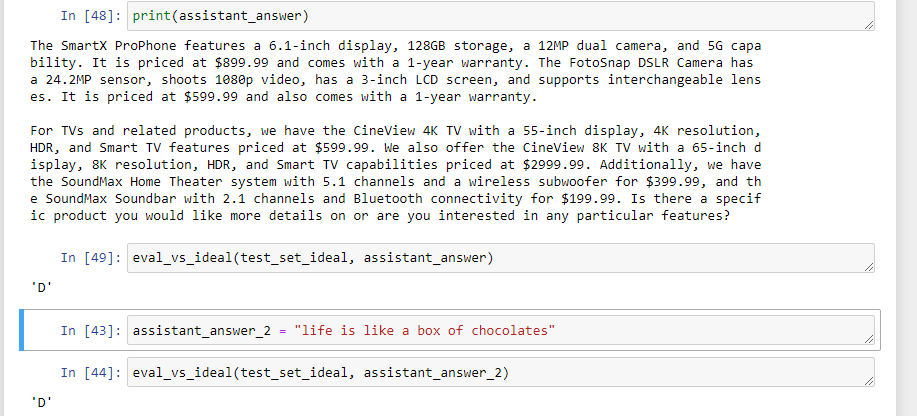